In [5]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import sys
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [6]:
def keypose(filename):
    #data from csv file with filename = filename
    activity_df = pd.read_csv(filename)
    # number of classes = number of activities within each file
    num_of_classes = activity_df.label.max()
    
    # for each class, extract joint coordinates for processing
    # to calculate K.E 1/2(v^2)
    for x in range(1, (num_of_classes + 1)):
        class_df_active = activity_df[activity_df.label == x]
        """
        calculating velocity of each joint dimension dist/time
        using a sampling time interval of 0.033 secs
        """
        class_label = class_df_active.label
        class_df = class_df_active.drop('label', axis=1)   # drop column with class label

        #class_df = class_df.rolling(window=30).mean()         # simple moving average to smoothing data
        coord_dist = class_df.diff().fillna(0)                # diff between each frame and its preceding frame and fill NaNs with 0
        coord_dist = coord_dist.rolling(window=30).mean()
        # compute joint distances over time
        coord_dist = coord_dist ** 2                          # square each value used to compute euclidean distance of a joint movement over time
        # print("coordinate distance %s" % coord_dist)
        for i in range(0, len(coord_dist.columns), 3):
            euclid_dist = np.sqrt(coord_dist.iloc[:, i] + coord_dist.iloc[:, (i+1)] + coord_dist.iloc[:, (i+2)])    # from second frame calculate each joint distance across each frame
            if i == 0:
                joint_dist = euclid_dist
            else:
                joint_dist = pd.concat([joint_dist, euclid_dist], axis=1)
        velocity2 = ((joint_dist / 100)) #/ 0.033)      # convert to meter / second
        K_E = (((velocity2.sum(axis=1) ** 2) / 2).reset_index(drop=True))
        K_E_sma = K_E.rolling(window=15).mean()
        K_E_ema = K_E.rolling(window=30).mean()

        # plot kinetic energy vs frame number
        cumu_diff_KE = K_E - K_E.loc[30]
        diff_sum = cumu_diff_KE.loc[30:len(cumu_diff_KE)].sum()

        #locate crossovers 
        idx = np.argwhere(np.diff(np.sign(K_E_sma - K_E_ema)) != 0).reshape(-1) + 0 #find the crossover points of the moving averages
        idx = idx[29:len(idx)]
        #print('Index positions of key poses in an activity: %s' % idx)
        
        #get data of the selected key poses
        extract_poses = class_df_active.iloc[idx]
        if x == 1:
            key_pose = extract_poses
        else:
            key_pose = pd.concat([key_pose, extract_poses], axis=0)
        #print(key_pose)
        
        if x == 5:
            plt.figure(figsize=(15,5))
            
            #plt.subplot(121)
            raw_plt = plt.plot(K_E.index[30:len(K_E.index)], K_E[30:len(K_E.index)], color='black')
            plt.xlabel('frame number')
            plt.ylabel('Kinetic energy')
            
            #plt.subplot(122)
            sh_sma = plt.plot(K_E.index[30:len(K_E.index)], K_E_sma[30:len(K_E.index)], color='red')
            long_sma = plt.plot(K_E.index[30:len(K_E.index)], K_E_ema[30:len(K_E.index)], color='green')
            crossover = plt.plot(K_E.index[idx], K_E_ema[idx], 'bo')
            plt.legend([sh_sma[0], long_sma[0], raw_plt[0], crossover[0]], ['Short Moving Av. = 15', 'Long Moving Av. = 30', 'Actual KE', 'MA Crossovers'])
            plt.xlabel('frame number')
            plt.ylabel('Kinetic energy')
            
            plt.show()
        
        
    return key_pose #return keyframes selected

C:\Users\n0691844\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sign


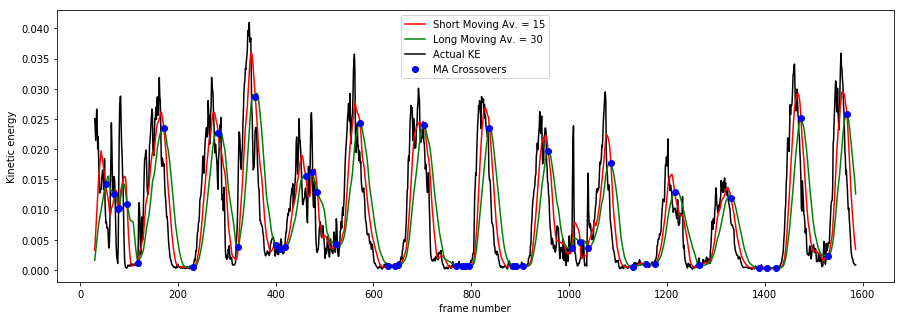

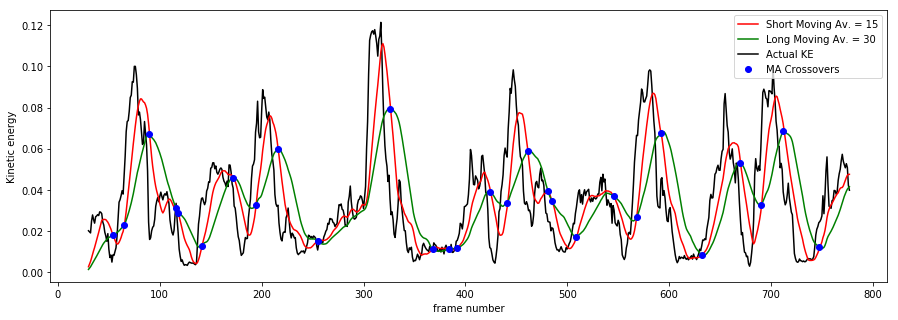

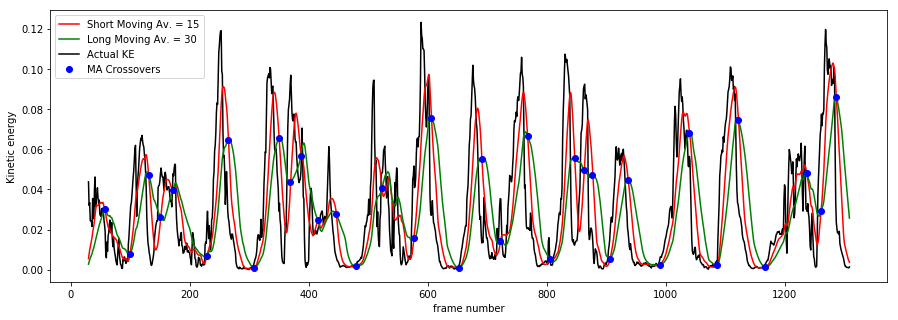

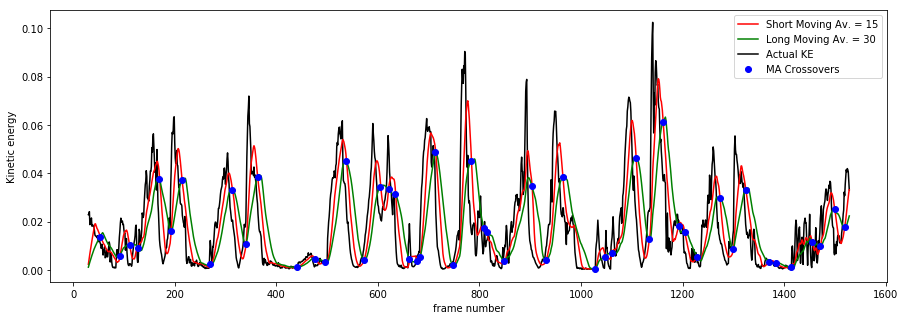

In [9]:
#keyframes selected from each person
keypose1 = keypose("C:/Users/n0691844/Dropbox/PhD personal docs/Resources/Cornell Univ data set/person1.csv")
keypose2 = keypose("C:/Users/n0691844/Dropbox/PhD personal docs/Resources/Cornell Univ data set/person2.csv")
keypose3 = keypose("C:/Users/n0691844/Dropbox/PhD personal docs/Resources/Cornell Univ data set/person3.csv")
keypose4 = keypose("C:/Users/n0691844/Dropbox/PhD personal docs/Resources/Cornell Univ data set/person4.csv")

#CAD-60 dataset
#keypose1 = keypose('C:/Users/n0691844/Dropbox/PhD personal docs/Resources/ActivityClassification/Data/CAD-60/person1.csv')
#keypose2 = keypose('C:/Users/n0691844/Dropbox/PhD personal docs/Resources/ActivityClassification/Data/CAD-60/person2.csv')
#keypose3 = keypose('C:/Users/n0691844/Dropbox/PhD personal docs/Resources/ActivityClassification/Data/CAD-60/person3.csv')
#keypose4 = keypose('C:/Users/n0691844/Dropbox/PhD personal docs/Resources/ActivityClassification/Data/CAD-60/person4.csv')

In [4]:
#import libraries for deep learning processing
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
#import keras_metrics
from sklearn.model_selection import train_test_split

C:\Users\n0691844\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
#create train and test dataset
data = [keypose1, keypose2, keypose3]
data = (pd.concat(data).reset_index(drop=True))
data_labels = data.label
act_data = data.drop('label', axis=1)
#print(data_labels)
#test_data = keypose4.reset_index(drop=True)
#test_label = test_data.label
#test_data = test_data.drop('label', axis=1)

In [6]:
#split train and test data
Xtrain, Xtest, Ytrain, Ytest = train_test_split(act_data, data_labels, test_size=0.40)
#Xtrain = act_data
#Xtest = test_data
#Ytrain = data_labels
#Ytest = test_label
Xtrain_lstm = np.reshape(Xtrain.values, (Xtrain.shape[0], 1, Xtrain.shape[1]))
Xtest_lstm = np.reshape(Xtest.values, (Xtest.shape[0], 1, Xtest.shape[1]))
#Xtrain = sequence.pad_sequences(Xtrain)
#Xtest = sequence.pad_sequences(Xtest)
#print(Xtrain)

Train on 946 samples, validate on 631 samples
Epoch 1/150
946/946 [==============================] - 3s 3ms/step - loss: 1.4216 - acc: 0.1829 - val_loss: 0.8641 - val_acc: 0.3439
Epoch 2/150
946/946 [==============================] - 0s 206us/step - loss: 0.7865 - acc: 0.3985 - val_loss: 0.7658 - val_acc: 0.3819
Epoch 3/150
946/946 [==============================] - 0s 196us/step - loss: 0.7461 - acc: 0.3615 - val_loss: 0.7082 - val_acc: 0.3106
Epoch 4/150
946/946 [==============================] - 0s 199us/step - loss: 0.6582 - acc: 0.5539 - val_loss: 0.6276 - val_acc: 0.5689
Epoch 5/150
946/946 [==============================] - 0s 208us/step - loss: 0.5572 - acc: 0.5962 - val_loss: 0.5258 - val_acc: 0.5689
Epoch 6/150
946/946 [==============================] - 0s 211us/step - loss: 0.4658 - acc: 0.6205 - val_loss: 0.4300 - val_acc: 0.7147
Epoch 7/150
946/946 [==============================] - 0s 201us/step - loss: 0.3892 - acc: 0.7812 - val_loss: 0.3558 - val_acc: 0.7987
Epoch 8/150

Epoch 61/150
946/946 [==============================] - 0s 204us/step - loss: 0.1666 - acc: 0.8742 - val_loss: 0.1703 - val_acc: 0.8621
Epoch 62/150
946/946 [==============================] - 0s 211us/step - loss: 0.1720 - acc: 0.8742 - val_loss: 0.1600 - val_acc: 0.8621
Epoch 63/150
946/946 [==============================] - 0s 249us/step - loss: 0.1577 - acc: 0.8721 - val_loss: 0.1736 - val_acc: 0.8605
Epoch 64/150
946/946 [==============================] - 0s 299us/step - loss: 0.1594 - acc: 0.8795 - val_loss: 0.1579 - val_acc: 0.8605
Epoch 65/150
946/946 [==============================] - 0s 286us/step - loss: 0.1557 - acc: 0.8795 - val_loss: 0.1706 - val_acc: 0.8653
Epoch 66/150
946/946 [==============================] - 0s 222us/step - loss: 0.1594 - acc: 0.8879 - val_loss: 0.1573 - val_acc: 0.8764
Epoch 67/150
946/946 [==============================] - 0s 192us/step - loss: 0.1552 - acc: 0.9091 - val_loss: 0.1603 - val_acc: 0.9144
Epoch 68/150
946/946 [==========================

946/946 [==============================] - 0s 226us/step - loss: 0.1216 - acc: 0.9662 - val_loss: 0.1466 - val_acc: 0.9493
Epoch 122/150
946/946 [==============================] - 0s 208us/step - loss: 0.1243 - acc: 0.9662 - val_loss: 0.1371 - val_acc: 0.9525
Epoch 123/150
946/946 [==============================] - 0s 206us/step - loss: 0.1227 - acc: 0.9672 - val_loss: 0.1245 - val_acc: 0.9556
Epoch 124/150
946/946 [==============================] - 0s 189us/step - loss: 0.1128 - acc: 0.9672 - val_loss: 0.1379 - val_acc: 0.9572
Epoch 125/150
946/946 [==============================] - 0s 200us/step - loss: 0.1141 - acc: 0.9672 - val_loss: 0.1278 - val_acc: 0.9556
Epoch 126/150
946/946 [==============================] - 0s 192us/step - loss: 0.1124 - acc: 0.9672 - val_loss: 0.1253 - val_acc: 0.9540
Epoch 127/150
946/946 [==============================] - 0s 184us/step - loss: 0.1117 - acc: 0.9662 - val_loss: 0.1440 - val_acc: 0.9572
Epoch 128/150
946/946 [==============================] 

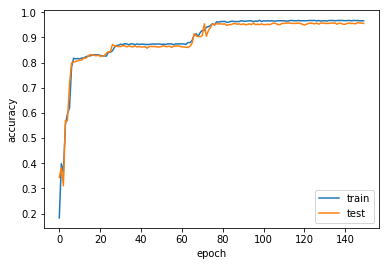

In [7]:
model = Sequential()
model.add(LSTM(100, input_shape=(1, 45)))
#model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(Xtrain_lstm, Ytrain, validation_data=(Xtest_lstm, Ytest), epochs=150, batch_size=30)
#final evaluation of model
scores = model.evaluate(Xtest_lstm, Ytest, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
#plt.title('LSTmodel accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
#model.predict_classes(Xtest_lstm)

In [8]:
from sklearn.metrics import classification_report
lstm_pred = model.predict(Xtest_lstm, verbose=0)
lstm_pred = np.rint(lstm_pred)
print(classification_report(Ytest, lstm_pred))

             precision    recall  f1-score   support

          1       0.98      0.99      0.99       120
          2       0.98      0.64      0.78        76
          3       0.96      1.00      0.98       217
          4       0.94      1.00      0.97       218

avg / total       0.96      0.96      0.95       631



In [9]:
#cross validation test for lstm classification
from sklearn.model_selection import KFold, StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
kf = StratifiedKFold(n_splits=4, shuffle=True)
cvscores = []
for train, test in kf.split(act_data, data_labels):
    Xtrain, Xtest, Ytrain, Ytest = act_data.iloc[train], act_data.iloc[test], data_labels.iloc[train], data_labels.iloc[test]
    Xtrain_lstm = np.reshape(Xtrain.values, (Xtrain.shape[0], 1, Xtrain.shape[1]))
    Xtest_lstm = np.reshape(Xtest.values, (Xtest.shape[0], 1, Xtest.shape[1]))
    model = Sequential()
    model.add(LSTM(100, input_shape=(1, 45)))
    #model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
    history = model.fit(Xtrain_lstm, Ytrain, validation_data=(Xtest_lstm, Ytest), epochs=150, batch_size=30)
    #final evaluation of model
    scores = model.evaluate(Xtest_lstm, Ytest, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    cvscores.append(scores[1]*100)
    #plt.plot(history.history['acc'])
    #plt.plot(history.history['val_acc'])
    #plt.title('LSTmodel accuracy')
    #plt.ylabel('accuracy')
    #plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='lower right')
    #plt.show()
    #model.predict_classes(Xtest_lstm)
    from sklearn.metrics import classification_report
    lstm_pred = model.predict(Xtest_lstm, verbose=0)
    lstm_pred = np.rint(lstm_pred)
    print(classification_report(Ytest, lstm_pred))
print("Average accuracy = %.2f" % (np.mean(cvscores)))

Train on 1181 samples, validate on 396 samples
Epoch 1/150
1181/1181 [==============================] - 2s 1ms/step - loss: 1.2949 - acc: 0.1668 - val_loss: 0.8210 - val_acc: 0.3434
Epoch 2/150
1181/1181 [==============================] - 0s 182us/step - loss: 0.7666 - acc: 0.3446 - val_loss: 0.7584 - val_acc: 0.3232
Epoch 3/150
1181/1181 [==============================] - 0s 191us/step - loss: 0.6830 - acc: 0.4649 - val_loss: 0.6787 - val_acc: 0.5530
Epoch 4/150
1181/1181 [==============================] - 0s 185us/step - loss: 0.5678 - acc: 0.5817 - val_loss: 0.5631 - val_acc: 0.5606
Epoch 5/150
1181/1181 [==============================] - 0s 185us/step - loss: 0.4682 - acc: 0.6147 - val_loss: 0.4647 - val_acc: 0.6288
Epoch 6/150
1181/1181 [==============================] - 0s 194us/step - loss: 0.3787 - acc: 0.7832 - val_loss: 0.3839 - val_acc: 0.7828
Epoch 7/150
1181/1181 [==============================] - 0s 200us/step - loss: 0.3388 - acc: 0.8086 - val_loss: 0.3483 - val_acc: 0.7

1181/1181 [==============================] - 0s 187us/step - loss: 0.1164 - acc: 0.9627 - val_loss: 0.1342 - val_acc: 0.9596
Epoch 120/150
1181/1181 [==============================] - 0s 180us/step - loss: 0.1260 - acc: 0.9619 - val_loss: 0.1601 - val_acc: 0.9520
Epoch 121/150
1181/1181 [==============================] - 0s 184us/step - loss: 0.1163 - acc: 0.9619 - val_loss: 0.1326 - val_acc: 0.9596
Epoch 122/150
1181/1181 [==============================] - 0s 185us/step - loss: 0.1229 - acc: 0.9636 - val_loss: 0.1248 - val_acc: 0.9596
Epoch 123/150
1181/1181 [==============================] - 0s 188us/step - loss: 0.1165 - acc: 0.9594 - val_loss: 0.1137 - val_acc: 0.9596
Epoch 124/150
1181/1181 [==============================] - 0s 183us/step - loss: 0.1122 - acc: 0.9627 - val_loss: 0.1212 - val_acc: 0.9596
Epoch 125/150
1181/1181 [==============================] - 0s 179us/step - loss: 0.1122 - acc: 0.9610 - val_loss: 0.1171 - val_acc: 0.9596
Epoch 126/150
1181/1181 [================

1181/1181 [==============================] - 0s 198us/step - loss: 0.1287 - acc: 0.9551 - val_loss: 0.1251 - val_acc: 0.9520
Epoch 85/150
1181/1181 [==============================] - 0s 213us/step - loss: 0.1339 - acc: 0.9534 - val_loss: 0.1268 - val_acc: 0.9520
Epoch 86/150
1181/1181 [==============================] - 0s 191us/step - loss: 0.1361 - acc: 0.9500 - val_loss: 0.1358 - val_acc: 0.9545
Epoch 87/150
1181/1181 [==============================] - 0s 204us/step - loss: 0.1263 - acc: 0.9551 - val_loss: 0.1485 - val_acc: 0.9571
Epoch 88/150
1181/1181 [==============================] - 0s 195us/step - loss: 0.1273 - acc: 0.9534 - val_loss: 0.1390 - val_acc: 0.9571
Epoch 89/150
1181/1181 [==============================] - 0s 183us/step - loss: 0.1255 - acc: 0.9551 - val_loss: 0.1260 - val_acc: 0.9571
Epoch 90/150
1181/1181 [==============================] - 0s 181us/step - loss: 0.1349 - acc: 0.9534 - val_loss: 0.1403 - val_acc: 0.9520
Epoch 91/150
1181/1181 [=======================

Epoch 50/150
1184/1184 [==============================] - 0s 196us/step - loss: 0.1723 - acc: 0.9198 - val_loss: 0.1523 - val_acc: 0.9059
Epoch 51/150
1184/1184 [==============================] - 0s 187us/step - loss: 0.1709 - acc: 0.9206 - val_loss: 0.1639 - val_acc: 0.9288
Epoch 52/150
1184/1184 [==============================] - 0s 182us/step - loss: 0.1614 - acc: 0.9367 - val_loss: 0.1817 - val_acc: 0.9237
Epoch 53/150
1184/1184 [==============================] - 0s 182us/step - loss: 0.1674 - acc: 0.9367 - val_loss: 0.1590 - val_acc: 0.9415
Epoch 54/150
1184/1184 [==============================] - 0s 192us/step - loss: 0.1492 - acc: 0.9434 - val_loss: 0.1399 - val_acc: 0.9415
Epoch 55/150
1184/1184 [==============================] - 0s 202us/step - loss: 0.1513 - acc: 0.9468 - val_loss: 0.1622 - val_acc: 0.9338
Epoch 56/150
1184/1184 [==============================] - 0s 188us/step - loss: 0.1470 - acc: 0.9510 - val_loss: 0.1398 - val_acc: 0.9415
Epoch 57/150
1184/1184 [==========

1185/1185 [==============================] - 0s 187us/step - loss: 0.2437 - acc: 0.8253 - val_loss: 0.2384 - val_acc: 0.8189
Epoch 16/150
1185/1185 [==============================] - 0s 184us/step - loss: 0.2420 - acc: 0.8262 - val_loss: 0.2349 - val_acc: 0.8291
Epoch 17/150
1185/1185 [==============================] - 0s 185us/step - loss: 0.2512 - acc: 0.8245 - val_loss: 0.2301 - val_acc: 0.8214
Epoch 18/150
1185/1185 [==============================] - 0s 203us/step - loss: 0.2316 - acc: 0.8253 - val_loss: 0.2319 - val_acc: 0.8240
Epoch 19/150
1185/1185 [==============================] - 0s 188us/step - loss: 0.2354 - acc: 0.8236 - val_loss: 0.2180 - val_acc: 0.8240
Epoch 20/150
1185/1185 [==============================] - 0s 184us/step - loss: 0.2207 - acc: 0.8245 - val_loss: 0.2129 - val_acc: 0.8265
Epoch 21/150
1185/1185 [==============================] - 0s 188us/step - loss: 0.2266 - acc: 0.8253 - val_loss: 0.2117 - val_acc: 0.8316
Epoch 22/150
1185/1185 [=======================

Epoch 133/150
1185/1185 [==============================] - 0s 186us/step - loss: 0.1211 - acc: 0.9586 - val_loss: 0.1143 - val_acc: 0.9617
Epoch 134/150
1185/1185 [==============================] - 0s 186us/step - loss: 0.1271 - acc: 0.9595 - val_loss: 0.1059 - val_acc: 0.9668
Epoch 135/150
1185/1185 [==============================] - 0s 193us/step - loss: 0.1152 - acc: 0.9595 - val_loss: 0.1061 - val_acc: 0.9668
Epoch 136/150
1185/1185 [==============================] - 0s 193us/step - loss: 0.1100 - acc: 0.9595 - val_loss: 0.1064 - val_acc: 0.9668
Epoch 137/150
1185/1185 [==============================] - 0s 192us/step - loss: 0.1158 - acc: 0.9595 - val_loss: 0.1094 - val_acc: 0.9694
Epoch 138/150
1185/1185 [==============================] - 0s 187us/step - loss: 0.1221 - acc: 0.9578 - val_loss: 0.1188 - val_acc: 0.9694
Epoch 139/150
1185/1185 [==============================] - 0s 184us/step - loss: 0.1239 - acc: 0.9595 - val_loss: 0.1150 - val_acc: 0.9668
Epoch 140/150
1185/1185 [==

In [10]:
#cross validation test for lstm classification
from sklearn.model_selection import KFold, StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
kf = StratifiedKFold(n_splits=4, shuffle=True)
cvscores = []
def create_model():
    model = Sequential()
    model.add(LSTM(100, input_shape=(1, 45)))
    #model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
    return model
Xtrain_lstm = np.reshape(act_data.values, (act_data.shape[0], 1, act_data.shape[1]))
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=30, verbose=0)
results = cross_val_score(model, Xtrain_lstm, data_labels, cv = kf)
#results = np.rint(results)
print(results.mean())
#print(accuracy_score(data_labels, results))
#print(classification_report(data_labels, results))

0.9632004119982247


In [11]:
#Single fold validation
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
clf = svm.SVC(decision_function_shape='ovo')
#clf.fit(Xtrain, Ytrain)
#pred = clf.predict(Xtest)
#accuracy_score(Ytest, pred)
#print(classification_report(Ytest, pred))

In [12]:
#Cross validation using 4 folds
from sklearn.model_selection import cross_val_predict
cross_val_pred = cross_val_predict(clf, act_data, data_labels, cv = 20)
print(accuracy_score(data_labels, cross_val_pred))
print(classification_report(data_labels, cross_val_pred))

0.9004438807863031
             precision    recall  f1-score   support

          1       0.86      0.92      0.89       286
          2       0.81      0.44      0.57       202
          3       1.00      1.00      1.00       527
          4       0.85      0.96      0.90       562

avg / total       0.90      0.90      0.89      1577



In [13]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(Xtrain, Ytrain)
knn_pred = neigh.predict(Xtest)
accuracy_score(Ytest, knn_pred)

1.0

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(Xtrain, Ytrain)
rf_pred = rf.predict(Xtest)
accuracy_score(Ytest, rf_pred)

1.0